1. Loading a torchdms model from a file:

This requires torchdms

In [3]:
import torch

def load_model(model_path: str):
    model = torch.load(model_path)
    return model

model_path = "Linear.model"

torchdms_model = load_model(model_path)

2. Evaluating phenotype from the model using input sequences (and labeling)

In [66]:
import pandas as pd, csv
from Bio import SeqIO
from Bio.Seq import Seq

# take in csv file of DMS sequences (excluding naive)
def aa_seqs_from_csv(csv_path: str):
    aa_seqs = []
    with open(csv_path, 'r') as F:
        reader = csv.DictReader(F)
        for row in reader:
            if str(row['name']).lower() != 'naive':
                aa_seqs.append(row['aa_sequence'])
    return aa_seqs


def fasta_to_df(f):
    """simply convert a fasta to dataframe"""

    ids, seqs = [], []
    with open(f) as fasta_file:
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            if str(seq_record.id) != 'naive':
                ids.append(seq_record.id)
                seqs.append(str(seq_record.seq))
    return pd.DataFrame({"id":ids, "seq":seqs})


def aa(sequence, frame):
    """Amino acid translation of nucleotide sequence in frame 1, 2, or 3."""
    return Seq(
        sequence[(frame - 1): (frame - 1
                               + (3 * ((len(sequence) - (frame - 1)) // 3)))]
    ).translate()

igh_frame = 1
igk_frame = 1
igk_idx = 336
naive_sites_path = "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv"

# collect the correct sites df from tylers repo
pos_df = pd.read_csv(
        naive_sites_path,
        dtype=dict(site=pd.Int16Dtype()),
        index_col="site_scFv",
    )

# evaluate sequences using torchdms model and return the evaluation as a pandas dataframe
def evaluate(torchdms_model, seqs: list[str], phenotype_names: list[str]):
    aa_seq_one_hot = torch.stack([torchdms_model.seq_to_binary(seq) for seq in seqs])
    try:
        labeled_evaluation = pandas.DataFrame(torchdms_model(aa_seq_one_hot).detach().numpy(), columns=phenotype_names)
    except ValueError:
        print("Incorrect number of column labels for phenotype data")
    return labeled_evaluation

# load the seqs from a fasta
fasta_path = "gcreplay_samples/gctree_PR1.10-12-LP-124-GC.fasta"
seqs_df = fasta_to_df(fasta_path)

# Well make a prediction for each of the observed sequences
for idx, row in seqs_df.iterrows():

    # translate heavy and light chains
    igh_aa = aa(row.seq[:igk_idx], igh_frame)
    igk_aa = aa(row.seq[igk_idx:], igk_frame)

    # Make the aa seq for tdms
    aa_tdms = pos_df.amino_acid.copy()
    aa_tdms.iloc[pos_df.chain == "H"] = igh_aa
    # note: replay light chains are shorter than dms seq by one aa
    aa_tdms.iloc[(pos_df.chain == "L") & (pos_df.index < pos_df.index[-1])] = igk_aa
    aa_tdms_seq = "".join(aa_tdms)
    seqs_df.loc[idx, "aa_sequence"] = aa_tdms_seq

phenotype_evaluation = evaluate(torchdms_model, seqs_df["aa_sequence"], ['delta_log10_KD', 'expression'])

3. Infer fitness by calculating the fraction of antigen bound

Uses Hill equation to infer fraction of antibodies that have antigen bound (theta) and plots as a histogram

     concentration_antigen  frac_antigen_bound
0             1.000000e-06            0.998971
1             1.000000e-06            0.999470
2             1.000000e-06            0.999100
3             1.000000e-06            0.999984
4             1.000000e-06            0.999986
..                     ...                 ...
325           1.000000e-10            0.081602
326           1.000000e-10            0.332838
327           1.000000e-10            0.219827
328           1.000000e-10            0.084464
329           1.000000e-10            0.203384

[330 rows x 2 columns]


/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 10 rows containing missing values.


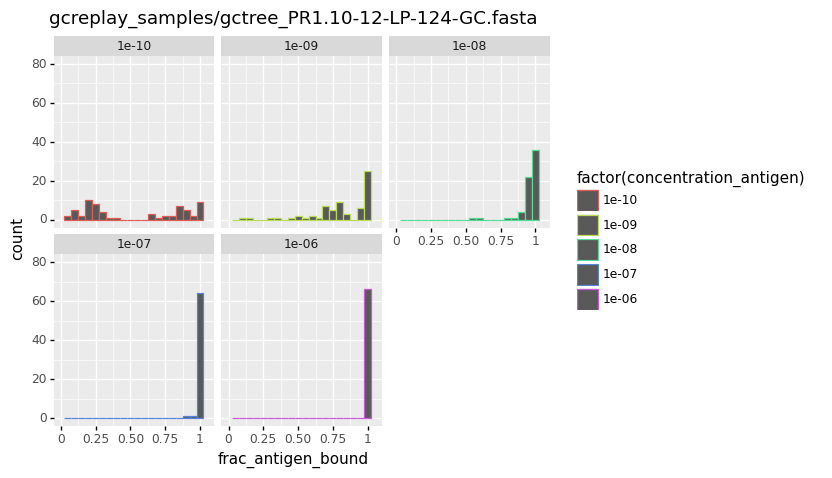

<ggplot: (8791385601913)>

In [67]:
from plotnine import ggplot, geom_histogram, aes, facet_wrap, ggtitle, xlim, ylim
import numpy

def frac_antigen_bound(delta_log10_KD: float, log10_naive_KD: float, concentration_antigen: float):
    log10_KD  = delta_log10_KD + log10_naive_KD
    KD = 10**log10_KD
    # Hill equation with n = 1:
    theta = concentration_antigen/(KD + concentration_antigen)
    return theta

log10_naive_KD = -10.43

antigen_bound_fracs = []
concentrations = []
for c in range(6,11): # concentration of antigen from 10^-6 to 10^-10
    concentration_antigen = 10**(-1*c)
    for delta_log10_KD in phenotype_evaluation['delta_log10_KD']:
        antigen_bound_fracs.append(frac_antigen_bound(delta_log10_KD, log10_naive_KD, concentration_antigen))
        concentrations.append(concentration_antigen)

antigen_bound_df = pd.DataFrame({"concentration_antigen": concentrations, "frac_antigen_bound": antigen_bound_fracs})
print(antigen_bound_df)

ggplot(antigen_bound_df) + facet_wrap(facets="~concentration_antigen") + aes(x="frac_antigen_bound", color='factor(concentration_antigen)') + geom_histogram(binwidth=0.05) + xlim(0,1.05) +ylim(0,80)  + ggtitle(fasta_path)

4. Mapping to fitness

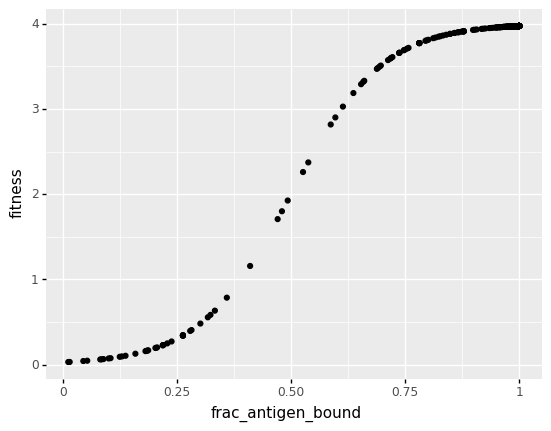

<ggplot: (8791383435668)>

In [112]:
from plotnine import geom_point
from math import exp
def antigen_bound_Tfh_help_sigmoid(antigen_bound: float, k: float, α: float, β: float):
    x = α * (antigen_bound - β)
    Tfh = k/(1 + exp(-1 * x))
    return Tfh

def antigen_bound_Tfh_help_linear(antigen_bound: float, k: float, antigen_concentration: float):
    Tfh = antigen_bound*k
    return Tfh

def fitness_from_Tfh_help(Tfh_help: float, c: float):
    return c*Tfh_help

α = 10
β = .5
k = 4
c = 1

def map_antigen_bound(antigen_bound_fracs: list[float]):
    fitnesses = []
    for antigen_bound_frac in antigen_bound_fracs:
        Tfh_help = antigen_bound_Tfh_help_sigmoid(antigen_bound_frac, k, α, β)
        fitnesses.append(fitness_from_Tfh_help(Tfh_help, c))
    return fitnesses

fitness_df = antigen_bound_df.assign(fitness=map_antigen_bound(antigen_bound_df['frac_antigen_bound']))

ggplot(fitness_df) + aes(x="frac_antigen_bound", y = "fitness") + geom_point()